In [1]:
import sys
import os
from time import time
import pandas as pd
import numpy as np
import mlutils
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from sklearn.metrics import confusion_matrix
from __future__ import division

/opt/miniconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 80
  from .murmurhash import murmurhash3_32
/opt/miniconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 144
  from .murmurhash import murmurhash3_32
/opt/miniconda/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 80
  from . import _hashing
/opt/miniconda/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:9: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 144
  from . import _hashing
/opt/miniconda/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Exp

In [2]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image  import ImageDataGenerator, array_to_img, img_to_array, load_img  #Para preprocesar las iamgenes que le vamos a dar para entrenar nuestro algoritmo
#from tensorflow.python.keras import optimizers, Input,Model   # esto funciona con esta linea y luego llamando como .tf import tensorflow as tf layers = tf.keras.layers.Flatten()(layers)
#from tensorflow.python.keras.models  import Sequential  #Librería para hacer las redes neuronales secuenciales
#from tensorflow.python.keras.layers import  Dropout, Flatten, Dense, Activation
#from tensorflow.python.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as K
#from tensorflow.python.keras import applications


#from keras.preprocessing.image import load_img, img_to_array
#from keras.models import load_model

In [3]:
os.environ['PYTHONHASHSEED']='0'
np.random.seed(111)
sesion_conf=tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
tf.set_random_seed(111)
sess=tf.Session(graph=tf.get_default_graph(),config=sesion_conf)
K.set_session(sess)
#aug.seed(111)

In [4]:
Path='/home/user/20191.DL-master/Proyecto U3 v2/Pictures'
Files=os.listdir(Path)
Files
#os.remove(Path+'/'+'.ipynb_checkpoints')

['Azimuth310', '.ipynb_checkpoints', 'Azimuth350', 'Azimuth0']

In [5]:
des_organized_data=0
if des_organized_data==1:
    #if not os.path.exists(Path+'/Train'):
    #      os.mkdir(Path+'/Train')

    #if not os.path.exists(Path+'/Test'):
    #      os.mkdir(Path+'/Test')

    for fil in Files: 
        if fil.endswith('.tif'):
            Nam = fil.split('.')[0].split('_')
            Nam_class = Nam[len(Nam)-1].replace(' ','')        
            if not os.path.exists(Path+'/'+Nam_class):
                  os.mkdir(Path+'/'+Nam_class)
            os.rename(Path+'/'+fil,Path+'/'+Nam_class+'/'+fil)

In [6]:
K.clear_session()

ImageDataGenerator(rescale,shear_range,zoom_range,horizontal_flip)

zoom_range=0.3, #HACE ZOOM A LAS IMAGENES
horizontal_flip= True #DIRECCIONALIDAD DEL ALGORITMO

In [7]:
datagen = ImageDataGenerator(rescale=1./255., fill_mode='nearest')
img_size = 100
train_generator_fn = lambda: datagen.flow_from_directory(
        Path,  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=100,
        interpolation = "bilinear",
        class_mode='binary') 

Found 43 images belonging to 4 classes.
(43,) (43, 100, 100, 3) [1. 1. 3. 3. 3. 3. 3. 2. 1. 1. 3. 1. 2. 3. 2. 2. 2. 3. 1. 2. 1. 3. 1. 1.
 3. 2. 3. 1. 3. 2. 2. 1. 1. 1. 3. 1. 2. 1. 2. 2. 3. 3. 2.]


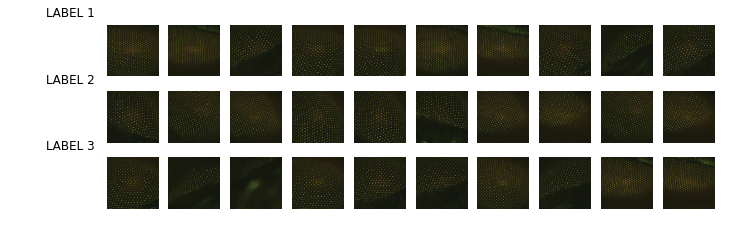

In [8]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
print labels.shape,imgs.shape,labels
mlutils.show_labeled_image_mosaic(imgs, labels)

In [9]:
print imgs.shape,labels.shape
print np.min(imgs[0]),np.min(imgs[1])

(43, 100, 100, 3) (43,)
0.04705883 0.043137256


In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train_0, y_test_0 = train_test_split(imgs, labels, test_size=.25)
y_train_0 = y_train_0-1
y_test_0 = y_test_0-1
y_train = np.array([int(i) for i in y_train_0])
y_test = np.array([int(i) for i in y_test_0])
num_classes = len(np.unique(y_train))
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()
print "\nnum classes", num_classes

(32, 100, 100, 3) (32,) (11, 100, 100, 3) (11,)

distribution of train classes
2    12
1    10
0    10
dtype: int64

distribution of test classes
0    5
2    3
1    3
dtype: int64

num classes 3


In [11]:
#crear la CNN
def get_conv_model_A(num_classes, img_size=100):
    
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    
    inputs = tf.keras.Input(shape=(img_size,img_size,3),name='Input')
    
    layers = tf.keras.layers.Convolution2D(32, (3,3), padding ="same", activation='relu')(inputs)
    layers = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(layers)

    layers = tf.keras.layers.BatchNormalization()(layers)
    
    layers = tf.keras.layers.Convolution2D(64, (2,2), padding ="same", activation='relu')(layers)
    layers = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(layers)

    #layers = tf.keras.layers.BatchNormalization()(layers)
    
    layers = tf.keras.layers.Flatten()(layers)
    
    layers = tf.keras.layers.Dense(256, activation='relu')(layers)
    layers = tf.keras.layers.Dense(16, activation='relu')(layers)
    layers = tf.keras.layers.Dropout(0.5)(layers)
    
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax',name='Output')(layers)

    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
def train(model, x_train, y_train, x_test, y_test, batch_size, epochs, model_name=""):
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [13]:
def get_confusion_matrix(y_test,y_pred,num_classes,class_names,batch,epoc,save):
    if not os.path.exists('/home/user/20191.DL-master/Proyecto U3 v2/ConfusionMatrix'):
              os.mkdir('/home/user/20191.DL-master/Proyecto U3 v2/ConfusionMatrix') 
    cm=confusion_matrix(y_test,y_pred)
    cm = cm/np.sum(cm)
    cmap=plt.cm.Blues
    tick_marks = np.arange(num_classes)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks, class_names)
    if save==1:
        plt.savefig('/home/user/20191.DL-master/Proyecto U3 v2/ConfusionMatrix/'+'Model_B'+str(batch)+'_E'+str(epoc)+'.png',
                   bbox_inches='tight',format='png',dpi=600)

In [14]:
model = get_conv_model_A(num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
__________

In [15]:
train(model, x_train, y_train, x_test, y_test, batch_size=60, epochs=300, model_name="model_A")

Train on 32 samples, validate on 11 samples
Epoch 1/300
32/32 [==============================] - 2s 65ms/step - loss: 1.1554 - acc: 0.2500 - val_loss: 1.0927 - val_acc: 0.4545
Epoch 2/300
32/32 [==============================] - 0s 13ms/step - loss: 1.2193 - acc: 0.3750 - val_loss: 1.1072 - val_acc: 0.2727
Epoch 3/300
32/32 [==============================] - 0s 13ms/step - loss: 1.0009 - acc: 0.3750 - val_loss: 1.1059 - val_acc: 0.2727
Epoch 4/300
32/32 [==============================] - 1s 17ms/step - loss: 1.0653 - acc: 0.4688 - val_loss: 1.1087 - val_acc: 0.2727
Epoch 5/300
32/32 [==============================] - 1s 17ms/step - loss: 0.9851 - acc: 0.4375 - val_loss: 1.1170 - val_acc: 0.2727
Epoch 6/300
32/32 [==============================] - 1s 17ms/step - loss: 1.0914 - acc: 0.6250 - val_loss: 1.1109 - val_acc: 0.1818
Epoch 7/300
32/32 [==============================] - 1s 17ms/step - loss: 0.8054 - acc: 0.6562 - val_loss: 1.1065 - val_acc: 0.2727
Epoch 8/300
32/32 [=============

Epoch 63/300
32/32 [==============================] - 0s 13ms/step - loss: 0.2671 - acc: 0.8438 - val_loss: 1.0637 - val_acc: 0.7273
Epoch 64/300
32/32 [==============================] - 1s 19ms/step - loss: 0.3283 - acc: 0.7812 - val_loss: 1.0637 - val_acc: 0.7273
Epoch 65/300
32/32 [==============================] - 1s 17ms/step - loss: 0.3812 - acc: 0.7812 - val_loss: 1.0638 - val_acc: 0.7273
Epoch 66/300
32/32 [==============================] - 0s 13ms/step - loss: 0.3553 - acc: 0.8125 - val_loss: 1.0639 - val_acc: 0.7273
Epoch 67/300
32/32 [==============================] - 1s 24ms/step - loss: 0.2580 - acc: 0.7812 - val_loss: 1.0653 - val_acc: 0.7273
Epoch 68/300
32/32 [==============================] - 1s 18ms/step - loss: 0.2512 - acc: 0.8438 - val_loss: 1.0682 - val_acc: 0.7273
Epoch 69/300
32/32 [==============================] - 1s 18ms/step - loss: 0.1942 - acc: 0.9375 - val_loss: 1.0707 - val_acc: 0.7273
Epoch 70/300
32/32 [==============================] - 1s 18ms/step - 

Epoch 125/300
32/32 [==============================] - 1s 16ms/step - loss: 0.2349 - acc: 0.9062 - val_loss: 1.0568 - val_acc: 0.4545
Epoch 126/300
32/32 [==============================] - 1s 18ms/step - loss: 0.2083 - acc: 0.9375 - val_loss: 1.0560 - val_acc: 0.4545
Epoch 127/300
32/32 [==============================] - 1s 16ms/step - loss: 0.1763 - acc: 0.9062 - val_loss: 1.0561 - val_acc: 0.4545
Epoch 128/300
32/32 [==============================] - 1s 17ms/step - loss: 0.1031 - acc: 0.9375 - val_loss: 1.0549 - val_acc: 0.4545
Epoch 129/300
32/32 [==============================] - 1s 20ms/step - loss: 0.2341 - acc: 0.9375 - val_loss: 1.0560 - val_acc: 0.4545
Epoch 130/300
32/32 [==============================] - 1s 19ms/step - loss: 0.1903 - acc: 0.9062 - val_loss: 1.0561 - val_acc: 0.4545
Epoch 131/300
32/32 [==============================] - 0s 16ms/step - loss: 0.2587 - acc: 0.8438 - val_loss: 1.0585 - val_acc: 0.4545
Epoch 132/300
32/32 [==============================] - 1s 22ms

Epoch 187/300
32/32 [==============================] - 0s 13ms/step - loss: 0.2127 - acc: 0.8750 - val_loss: 1.0607 - val_acc: 0.4545
Epoch 188/300
32/32 [==============================] - 1s 18ms/step - loss: 0.3939 - acc: 0.8438 - val_loss: 1.0619 - val_acc: 0.3636
Epoch 189/300
32/32 [==============================] - 0s 14ms/step - loss: 0.3339 - acc: 0.8125 - val_loss: 1.0537 - val_acc: 0.4545
Epoch 190/300
32/32 [==============================] - 0s 14ms/step - loss: 0.1637 - acc: 0.9688 - val_loss: 1.0470 - val_acc: 0.4545
Epoch 191/300
32/32 [==============================] - 0s 14ms/step - loss: 0.3019 - acc: 0.8750 - val_loss: 1.0409 - val_acc: 0.4545
Epoch 192/300
32/32 [==============================] - 0s 14ms/step - loss: 0.1775 - acc: 0.9375 - val_loss: 1.0366 - val_acc: 0.4545
Epoch 193/300
32/32 [==============================] - 0s 13ms/step - loss: 0.1932 - acc: 0.9375 - val_loss: 1.0337 - val_acc: 0.4545
Epoch 194/300
32/32 [==============================] - 1s 18ms

Epoch 249/300
32/32 [==============================] - 1s 16ms/step - loss: 0.1799 - acc: 0.9375 - val_loss: 1.0031 - val_acc: 0.4545
Epoch 250/300
32/32 [==============================] - 0s 15ms/step - loss: 0.3258 - acc: 0.7500 - val_loss: 1.0086 - val_acc: 0.4545
Epoch 251/300
32/32 [==============================] - 0s 13ms/step - loss: 0.2438 - acc: 0.8438 - val_loss: 1.0081 - val_acc: 0.4545
Epoch 252/300
32/32 [==============================] - 0s 13ms/step - loss: 0.1765 - acc: 0.9375 - val_loss: 1.0084 - val_acc: 0.5455
Epoch 253/300
32/32 [==============================] - 0s 13ms/step - loss: 0.2007 - acc: 0.9688 - val_loss: 1.0159 - val_acc: 0.6364
Epoch 254/300
32/32 [==============================] - 0s 14ms/step - loss: 0.2549 - acc: 0.8438 - val_loss: 1.0229 - val_acc: 0.7273
Epoch 255/300
32/32 [==============================] - 0s 14ms/step - loss: 0.2447 - acc: 0.9062 - val_loss: 1.0273 - val_acc: 0.6364
Epoch 256/300
32/32 [==============================] - 1s 17ms

{'acc': 0.7272727489471436, 'loss': 0.9237322211265564}

In [16]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
class_names=['0','310','350']
Accuracy = np.mean(y_pred == y_test)
print('Accuracy = ', Accuracy*100, '%')

('Accuracy = ', 72.72727272727273, '%')


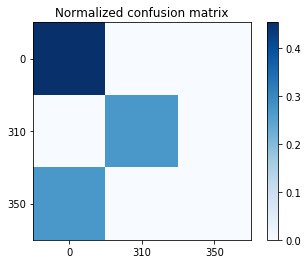

In [17]:
get_confusion_matrix(y_test,y_pred,num_classes,class_names,80,600,save=0)

Text(0,0.5,u'accuracy')

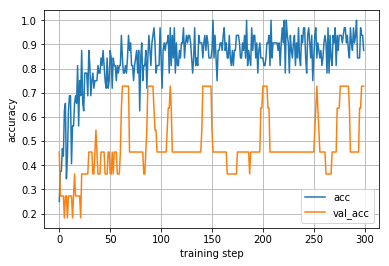

In [18]:
plt.plot(model.history.history["acc"], label="acc")
plt.plot(model.history.history["val_acc"], label="val_acc")
plt.grid()
plt.legend();
plt.xlabel("training step")
plt.ylabel("accuracy")
#    plt.ylim(0.4,1.05)

## Comparemos el efecto de diferentes batch_sizes y diferentes epocas.
Para esto, el código siguiente fue ejecutado, y los datos fueron guardados en un dataframe con nombre Acuracys.xlsx.

In [19]:
compare_parameters=0
batch_eval=[10,20,30,40,50,60,70,80,90,100]
epochs_eval=[100,200,300,400,500,600]
    
if compare_parameters==1:
    df=pd.DataFrame(columns=batch_eval,index=epochs_eval)

    for epoch,batch in itertools.product(epochs_eval,batch_eval):
        plt.close()
        model = get_conv_model_A(num_classes)
        train(model, x_train, y_train, x_test, y_test, batch_size=batch, epochs=epoch, model_name="model_A")
        y_pred = model.predict(x_test)
        y_pred = np.argmax(y_pred,axis=1)
        class_names=['0','310','350']
        Accuracy = np.mean(y_pred == y_test)
        print('Accuracy = ', Accuracy*100, '%')
        get_confusion_matrix(y_test,y_pred,num_classes,class_names,batch,epoch,save=1)
        df.loc[epoch,batch]=Accuracy
        #df.to_excel('/home/user/20191.DL-master/Proyecto U3 v2/ConfusionMatrix/Acuracys.xlsx')
else:
    df=pd.read_excel(open('/home/user/20191.DL-master/Proyecto U3 v2/ConfusionMatrix/Acuracys.xlsx','rb'))


In [20]:
df

,10,20,30,40,50,60,70,80,90,100
100,0.454545,0.636364,0.181818,0.727273,0.454545,0.272727,0.636364,0.454545,0.363636,0.363636
200,0.636364,0.636364,0.454545,0.545455,0.727273,0.636364,0.545455,0.363636,0.636364,0.454545
300,0.181818,0.545455,0.363636,0.636364,0.727273,0.727273,0.545455,0.727273,0.363636,0.545455
400,0.181818,0.727273,0.272727,0.727273,0.636364,0.636364,0.545455,0.545455,0.727273,0.545455
500,0.636364,0.727273,0.545455,0.636364,0.545455,0.636364,0.818182,0.636364,0.545455,0.818182
600,0.181818,0.636364,0.636364,0.545455,0.727273,0.636364,0.454545,0.909091,0.636364,0.636364


Text(0,0.5,u'Numero de neuronas')

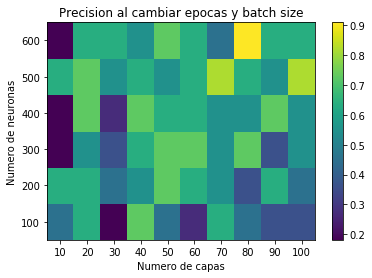

In [21]:
plt.figure()
plt.pcolor(df.astype(float))
plt.colorbar()
plt.title('Precision al cambiar epocas y batch size')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel('Numero de capas')
plt.ylabel('Numero de neuronas')

Text(0,0.5,u'Precision')

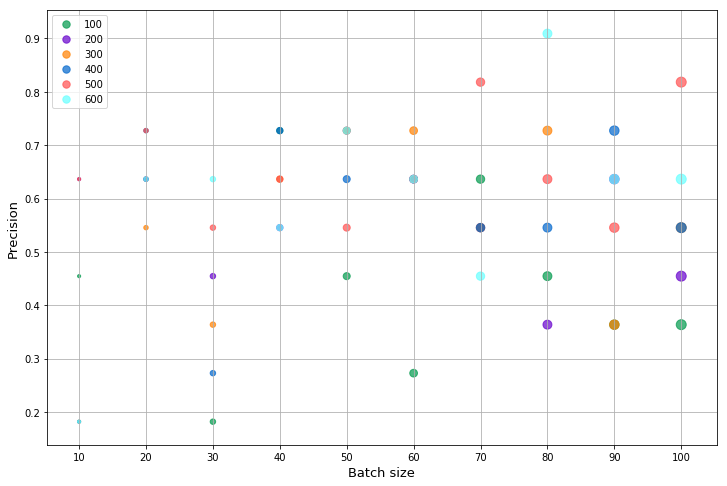

In [22]:
plt.figure(figsize=(12,8))

color={100:'#00994C',200:'#6600CC',300:'#FF8000',400:'#0066cc',500:'#ff5050',600:'#66ffff'}

for ep in epochs_eval:
    plt.scatter(x=df.loc[ep,:].index,y=df.loc[ep,:],
                s=50*ep*(df.loc[ep,:].index).values.tolist(),alpha=0.7,label=ep,color=color[ep])

plt.legend()
plt.grid()
plt.xticks(batch_eval)
plt.xlabel('Batch size',fontsize=13)
plt.ylabel('Precision',fontsize=13)